In [1]:
import numpy as np
import matplotlib.pyplot as plt
# XGBoost 
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error

In [4]:
np.random.seed(123)

CASE = 11

S = 2
N = 1000
N_train = 500
N_test  = N - N_train
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N) # float
for n in range(N):
    y[n] = -100.*x[n,0] 
    if CASE==11: y[n] += 100.*np.cos(3.14*x[n,1])
    if CASE==12: y[n] += -100.*x[n,1] 

x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

[ 0.78587674 -0.85544266] -168.39167391263723
[-1.09259419  0.20525908] 189.19863413401646
[ 0.87787588 -0.30757416] -30.91027271561145
[1.92305679 0.73931895] -260.51821147160183
[-0.07627239 -0.43152993] 29.03938677467515


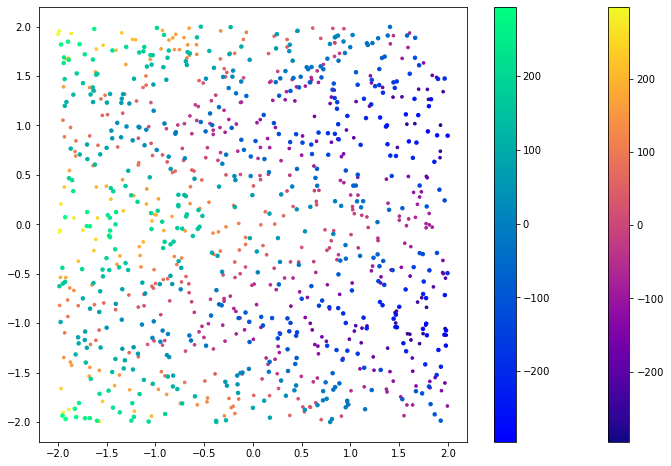

In [5]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)

for n in range(5):
    print(x[n],y[n])

plt.figure(figsize=(12,8))
scat(x_train,y_train,s=7)
plt.colorbar()
scat(x_test,y_test,cmap="winter",s=12)
plt.colorbar()
plt.show()

In [6]:
print(y[:4])

[-168.39167391  189.19863413  -30.91027272 -260.51821147]


In [90]:
def fit(xgbr=XGBRegressor(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default)
    xgbr.fit(x_train,y_train)
    y_hat = xgbr.predict(x_test)
    print("mean squared error: {:.2f}".format(mean_squared_error(y_hat, y_test)))
    if show: 
        dx = 0.02
        x_seq=np.arange(-S,S+dx,dx)
        nx = len(x_seq)
        x_plot=np.zeros((nx*nx,2))
        q=0
        for i in range(nx):
            for j in range(nx):
                x_plot[q,:] = [x_seq[i],x_seq[j]]
                q+=1
        y_plot= xgbr.predict(x_plot)

        plt.figure(figsize=(9.5,8))
        plt.title(str(xgbr))
        scat(x_plot,y_plot,cmap="winter",s=0.2)
        plt.colorbar()
        scat(x_train,y_train,s=7)
        plt.show()
    if show:      
        dump_list = xgbr.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(3,1,figsize=(30, 30))
        for i in range(min(3,num_trees)):
            ax=AX[i]
            plot_tree(xgbr, num_trees=i, ax=ax)
        fig.savefig("tree-fit.png", dpi=300, pad_inches=0.02)   
        plt.show()
        #plt.savefig("net"+str(t)+".png",dpi=300)
        plt.show()

mean squared error: 143.33


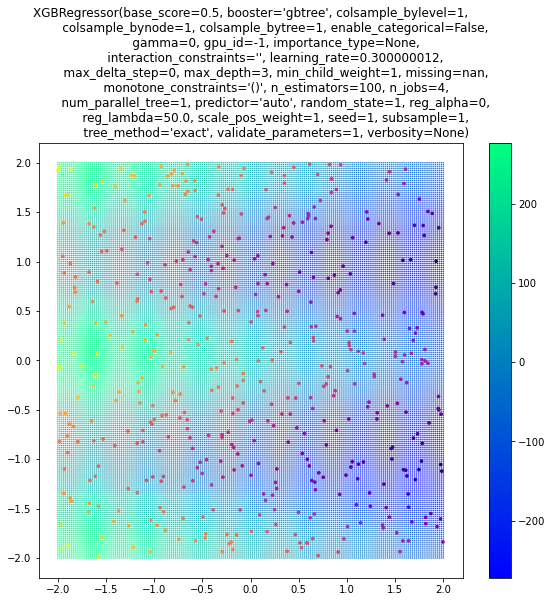

num_trees= 100


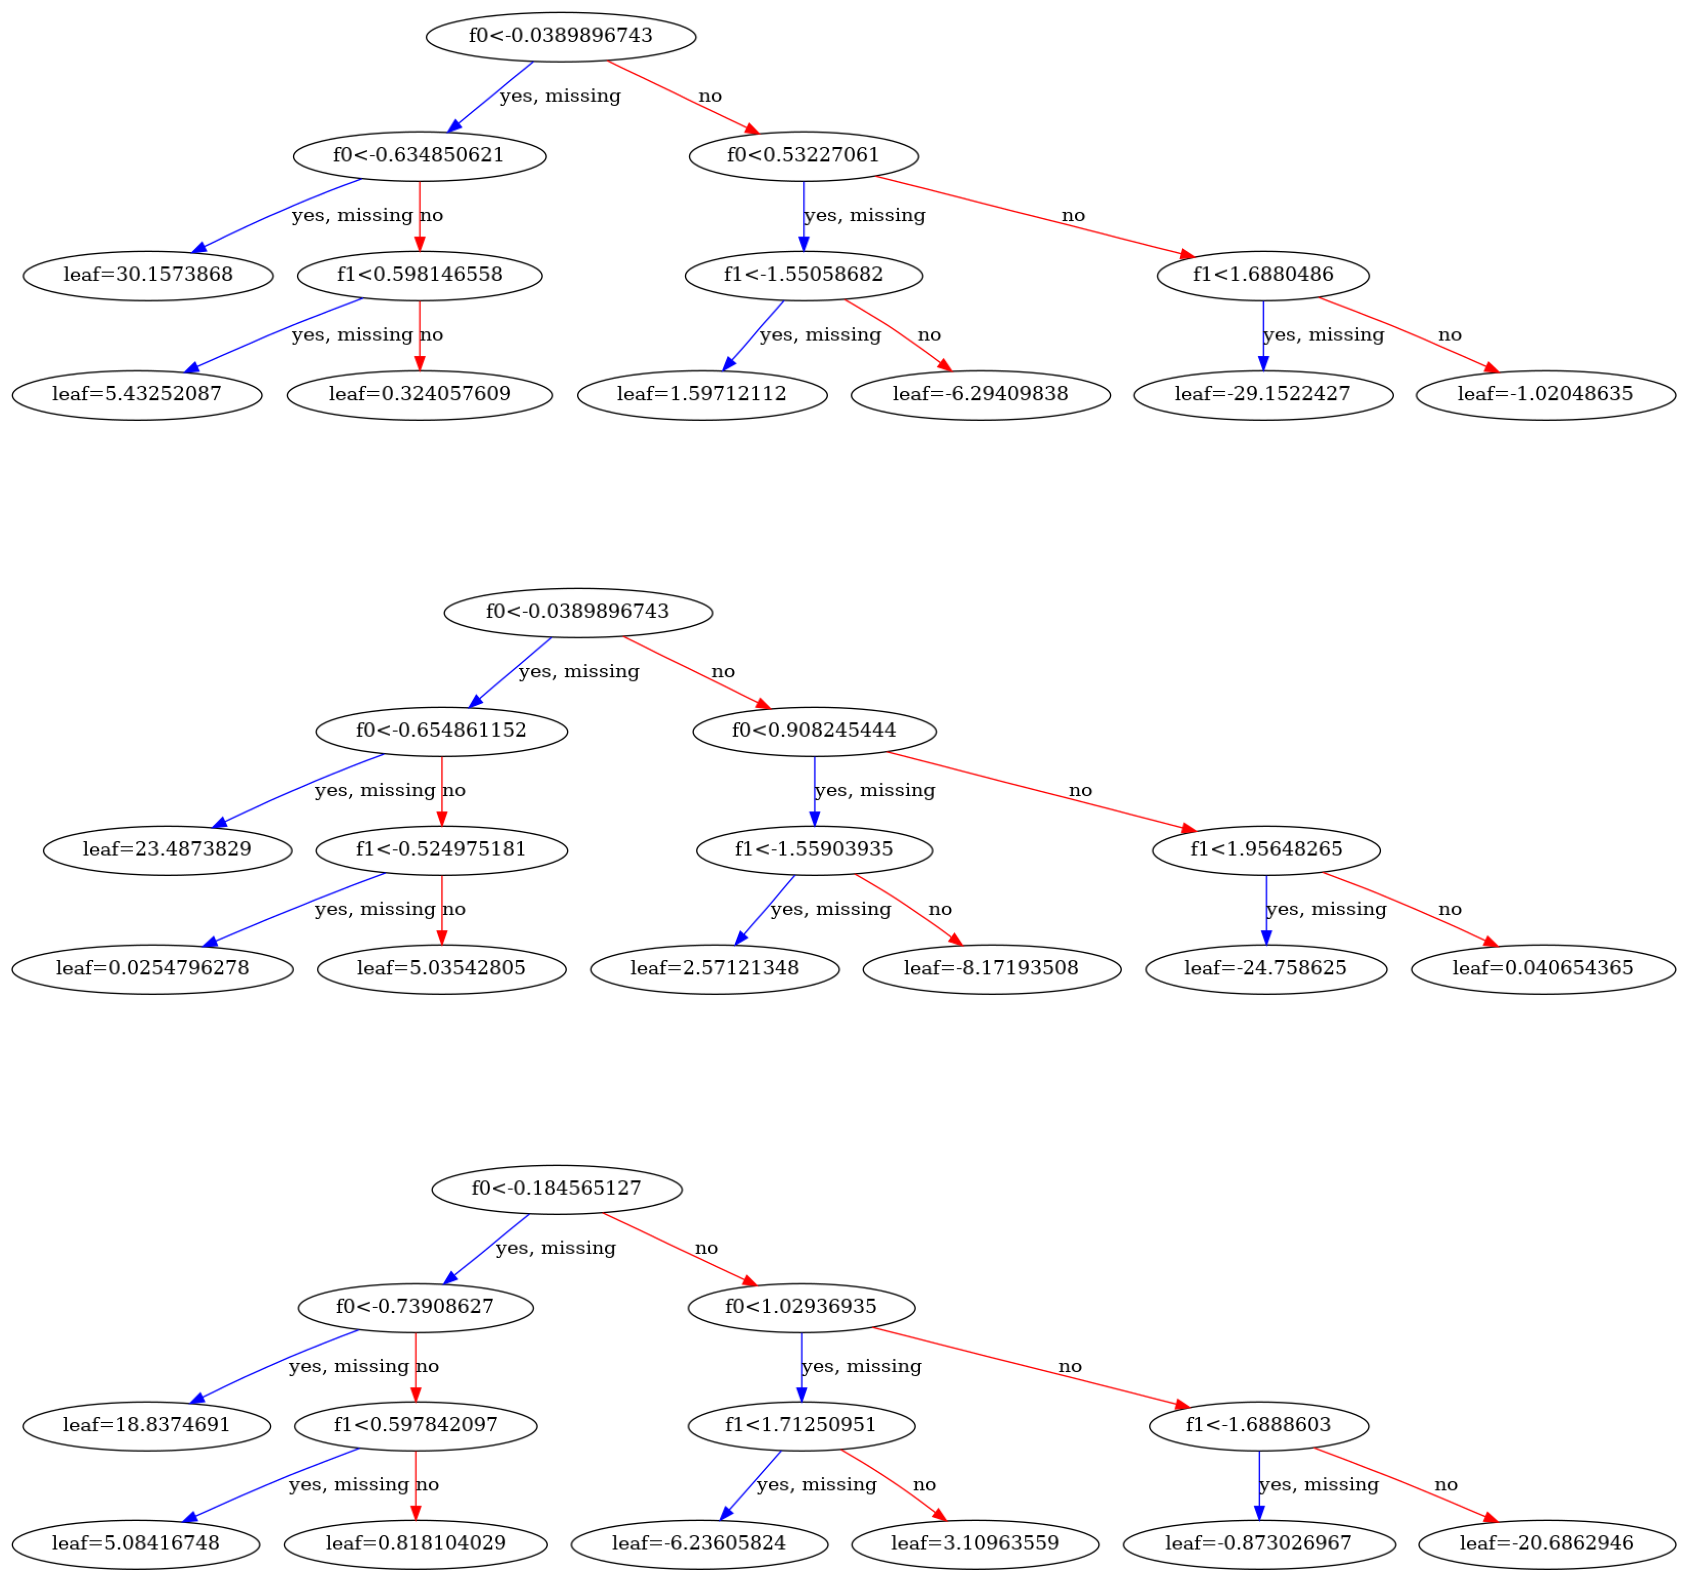

In [91]:
fit(XGBRegressor(seed=1,reg_lambda=50., n_estimators=100,max_depth=3),show=True)

## aiming to find the simplest yet effective XGBoost model that keeps a good accuracy

### 1- reg_lambda

In [70]:
lam=[100.,30,20.,10.,5.,1.,0.5,0.1]
for l in lam:
    print("lambda=",l)
    fit(XGBRegressor(seed=1,reg_lambda=l, n_estimators=100,max_depth=4))

lambda= 100.0
mean squared error: 218.64
lambda= 30
mean squared error: 142.29
lambda= 20.0
mean squared error: 128.49
lambda= 10.0
mean squared error: 137.28
lambda= 5.0
mean squared error: 131.75
lambda= 1.0
mean squared error: 146.00
lambda= 0.5
mean squared error: 160.90
lambda= 0.1
mean squared error: 171.44


### 2- gamma

In [71]:
gam=[0.,1.,2.,4.,10.,20.,40.,100.,200.]
for g in gam:
    print("gamma=",g)
    fit(XGBRegressor(seed=1,reg_lambda=20., gamma=g, n_estimators=100,max_depth=4))

gamma= 0.0
mean squared error: 128.49
gamma= 1.0
mean squared error: 130.57
gamma= 2.0
mean squared error: 130.00
gamma= 4.0
mean squared error: 129.06
gamma= 10.0
mean squared error: 132.33
gamma= 20.0
mean squared error: 128.36
gamma= 40.0
mean squared error: 137.49
gamma= 100.0
mean squared error: 168.60
gamma= 200.0
mean squared error: 198.58


### 3- n_estimators

In [76]:
ns=[100,200,300,400,500,600,700,800,900,1000]
for n in ns:
    print("n_estimators=",n)
    fit(XGBRegressor(seed=1,reg_lambda=20., gamma=0, n_estimators=n,max_depth=4))

n_estimators= 100
mean squared error: 128.49
n_estimators= 200
mean squared error: 98.01
n_estimators= 300
mean squared error: 90.16
n_estimators= 400
mean squared error: 87.16
n_estimators= 500
mean squared error: 84.93
n_estimators= 600
mean squared error: 83.76
n_estimators= 700
mean squared error: 83.11
n_estimators= 800
mean squared error: 82.51
n_estimators= 900
mean squared error: 81.98
n_estimators= 1000
mean squared error: 81.50


#### As we can see from the result , 1000 is the best. Although  with  number  biger than 1000 we will have better result , we want the simplest and effective model. So we chosse 500 that has a good accuracy and half complexity of 1000 

### 4- max_depth

In [78]:
mx=[1,2,3,4,5,6,7,8,9,10]
for m in mx:
    print("max_depth=",m)
    fit(XGBRegressor(seed=1,reg_lambda=20., gamma=0, n_estimators=500,max_depth=m))

max_depth= 1
mean squared error: 109.10
max_depth= 2
mean squared error: 52.22
max_depth= 3
mean squared error: 61.27
max_depth= 4
mean squared error: 84.93
max_depth= 5
mean squared error: 106.48
max_depth= 6
mean squared error: 121.75
max_depth= 7
mean squared error: 124.57
max_depth= 8
mean squared error: 129.20
max_depth= 9
mean squared error: 129.69
max_depth= 10
mean squared error: 134.69


### 5- learning_rate

In [96]:
lr=[0.8,1.,1.1,1.2,1.3,1.4,1.5]
for l in lr:
    print("learning_rate=",l)
    fit(XGBRegressor(seed=1,reg_lambda=20., gamma=0, n_estimators=500,max_depth=2,learning_rate=l))   

learning_rate= 0.8
mean squared error: 54.19
learning_rate= 1.0
mean squared error: 33.79
learning_rate= 1.1
mean squared error: 52.46
learning_rate= 1.2
mean squared error: 56.33
learning_rate= 1.3
mean squared error: 34.41
learning_rate= 1.4
mean squared error: 52.35
learning_rate= 1.5
mean squared error: 92.33


### 6- min_child_weight

In [80]:
mcw=[3,4,5,6]
for m in mcw:
    print("min_child_weight=",m)
    fit(XGBRegressor(seed=1,reg_lambda=20., gamma=0, n_estimators=500,max_depth=2,learning_rate=1
                     ,min_child_weight=m)) 

min_child_weight= 3
mean squared error: 34.59
min_child_weight= 4
mean squared error: 32.34
min_child_weight= 5
mean squared error: 34.35
min_child_weight= 6
mean squared error: 36.38


## Final Result

mean squared error: 32.34


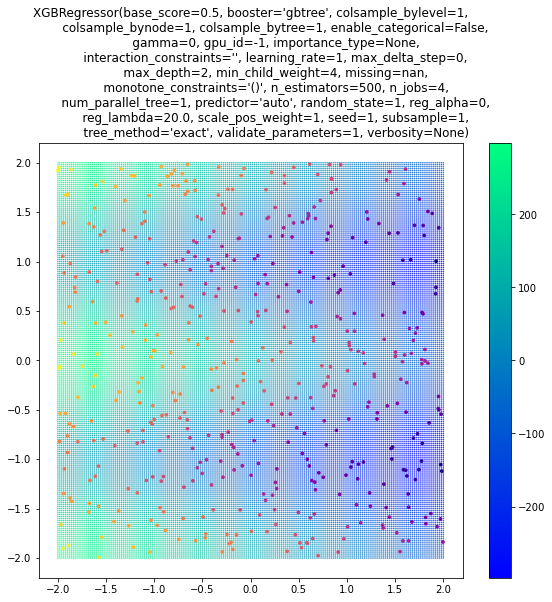

num_trees= 500


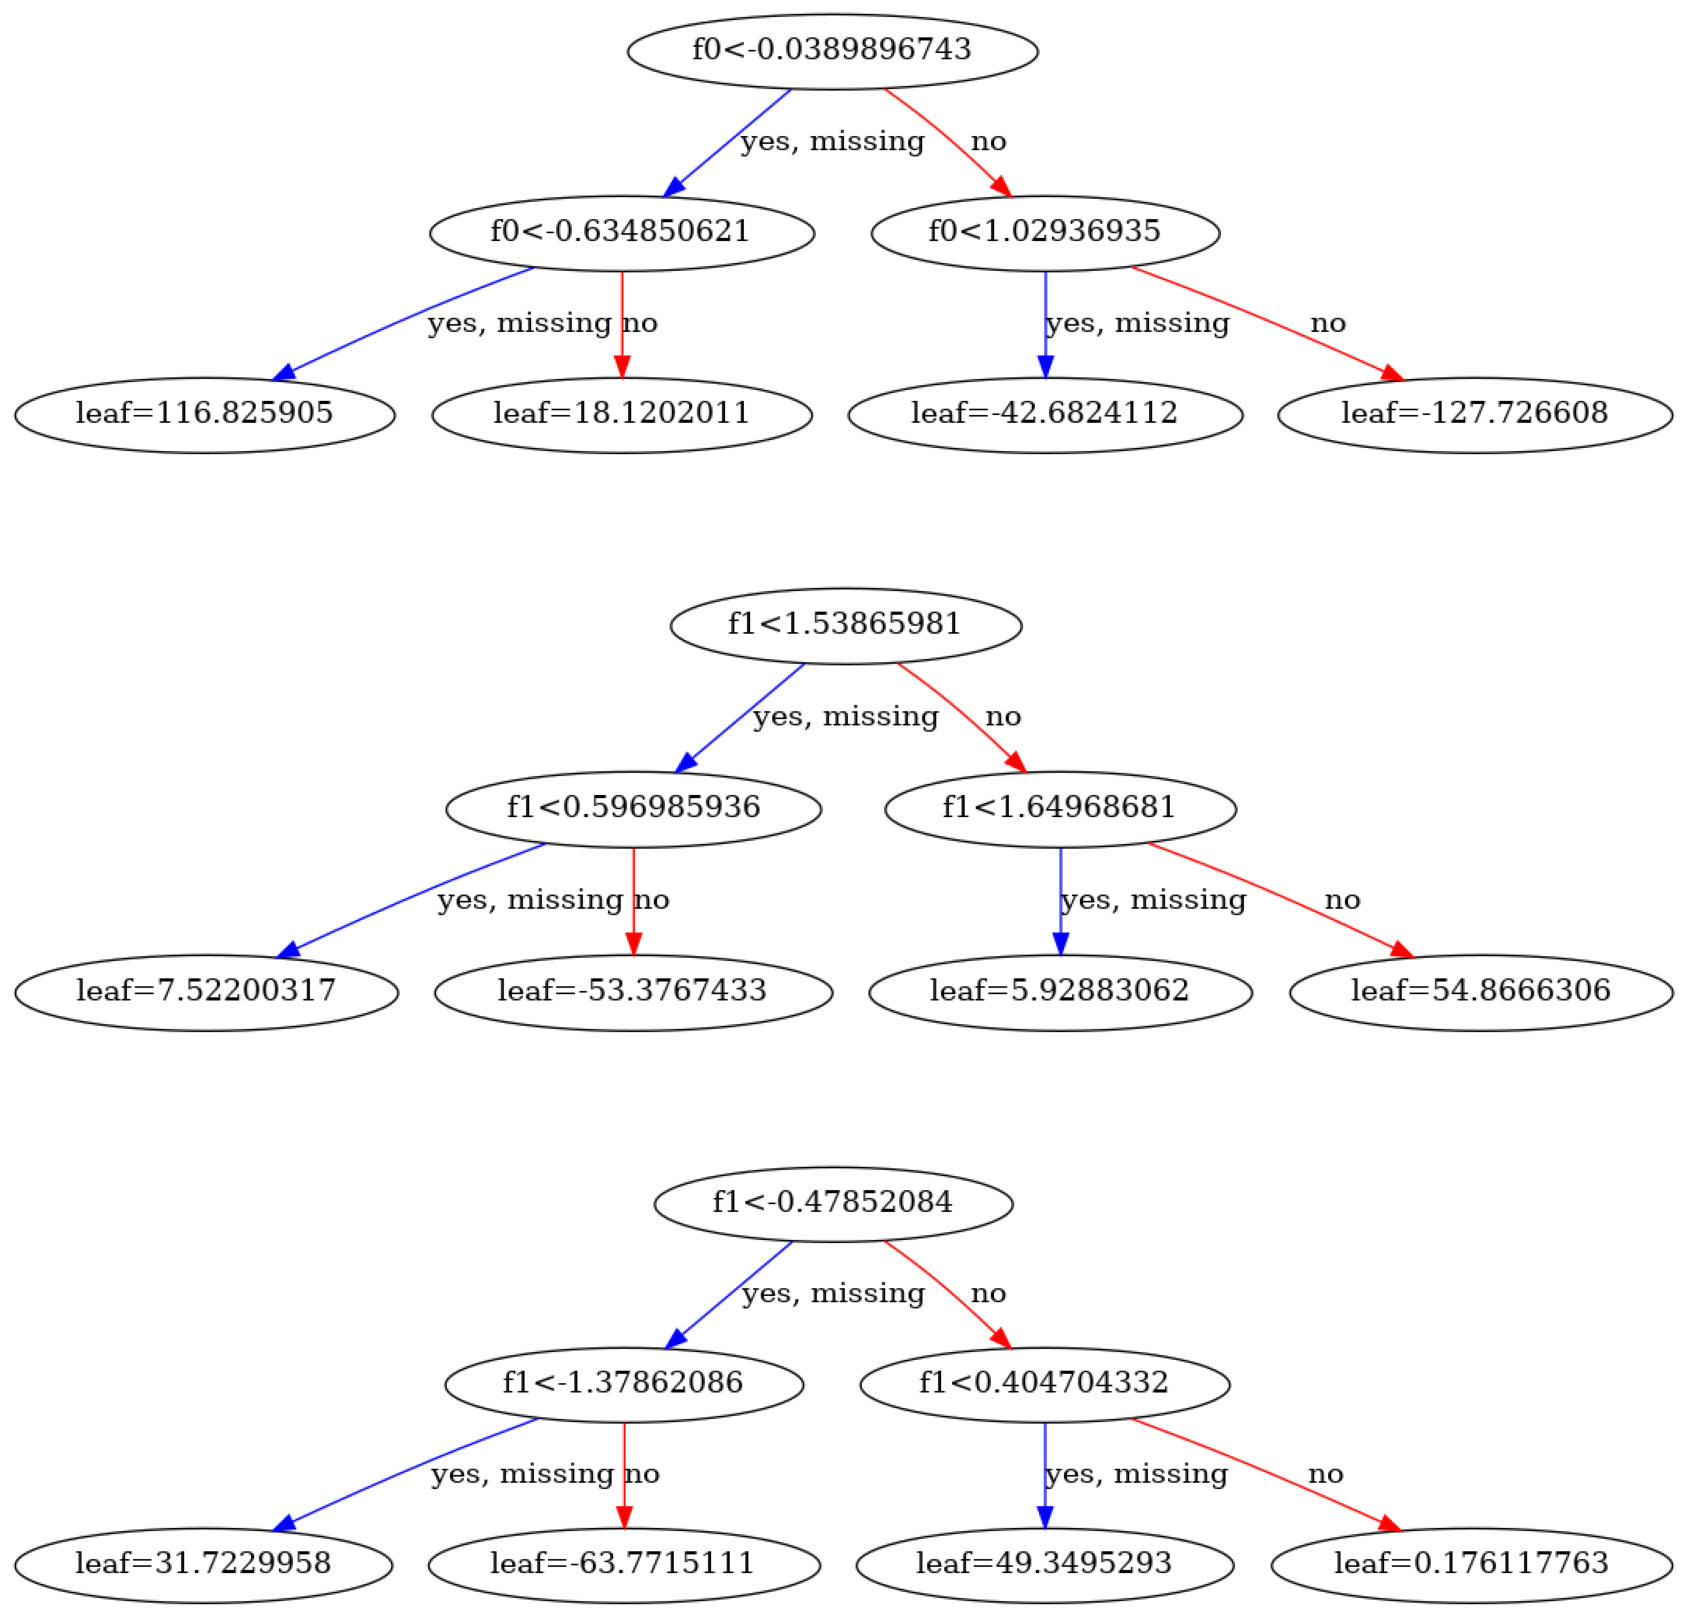

In [100]:
fit(XGBRegressor(seed=1,reg_lambda=20., gamma=0, n_estimators=500,max_depth=2,learning_rate=1
                     ,min_child_weight=4),show=True)